## Cleaning the data

Before beginning to build the model, the data needs to be cleaned. These are the issues that this notebook shall address:

1. Fix images with incorrect RescaleIntercept
2. Remove images if they have little useful information
3. Crop images to contain just the lungs
4. Histogram Rescaling

Based on [Cleaning the data for rapid prototyping (fastai)](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai)

In [1]:
from fastai.basics import *
from fastai.vision import *
from fastai.medical.imaging import *
import pickle as pkl

In [2]:
path = Path('osic-pulmonary-fibrosis-progression')
path_trn = path/'train'
path_tst = path/'test'

In [3]:
trn_lbls = pd.read_csv(path/'train.csv')
tst_lbls = pd.read_csv(path/'test.csv')

In [4]:
trn_itms = get_dicom_files(path_trn)
tst_itms = get_dicom_files(path_tst)

In [5]:
with open('training_dicom_metadata.pkl', 'rb') as f:
    df_trn = pkl.load(f)
print(len(df_trn), len(trn_lbls), len(trn_itms))

with open('testing_dicom_metadata.pkl', 'rb') as f:
    df_tst = pkl.load(f)
print(len(df_tst), len(tst_lbls), len(tst_itms))

33026 1549 33026
1261 5 1261


In [6]:
comb_trn = pd.merge(df_trn, trn_lbls, how='inner', left_on='PatientID', right_on='Patient')
comb_trn.drop_duplicates(subset=['fname'], inplace=True, ignore_index=True) # I don't know why it is creating duplicate rows, but there should only be one row per file
len(comb_trn), len(df_trn)

(33026, 33026)

In [7]:
comb_tst = pd.merge(df_tst, tst_lbls, how='inner', left_on='PatientID', right_on='Patient')
comb_tst.drop_duplicates(subset=['fname'], inplace=True, ignore_index=True)
len(comb_tst), len(df_tst)

(1261, 1261)

### Fix incorrect RescaleIntercept

When trying to build the model in model-building.ipynb, there were some errors and some values that didn't seem correct. In this section, I will explore what's happening/how to fix it

In [8]:
df1 = comb_trn.query('(BitsStored == 12)')
df2 = comb_trn.query('(BitsStored == 13)')
df3 = comb_trn.query('(BitsStored == 16) & (PixelRepresentation == 0)')
df4 = comb_trn.query('(BitsStored == 16) & (PixelRepresentation == 1)')
dfs = L(df1, df2, df3, df4)

In [9]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file


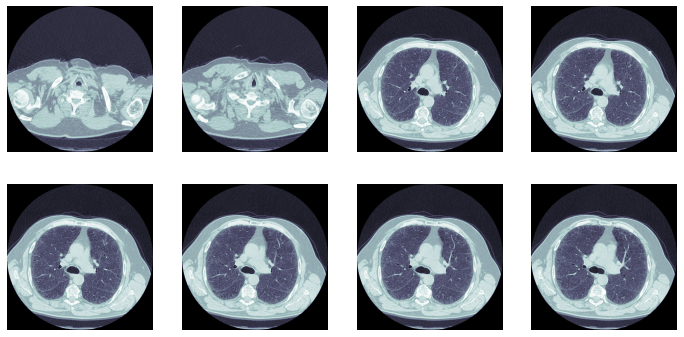

In [38]:
df_iffy = df2[df2.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

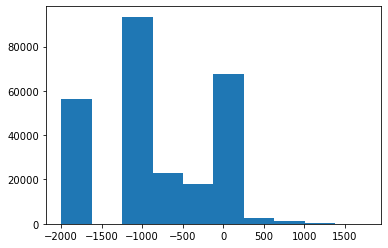

In [39]:
dcm = dcms[2]
d = dcm.pixel_array
plt.hist(d.flatten());

In [40]:
scipy.stats.mode(d.flatten()).mode[0] #mode should be zero

-2000

In [41]:
px_mode = scipy.stats.mode(d.flatten()).mode[0]
d[d>=px_mode] = d[d>=px_mode] - px_mode
dcm.PixelData = d.tobytes()
dcm.RescaleIntercept = -1000

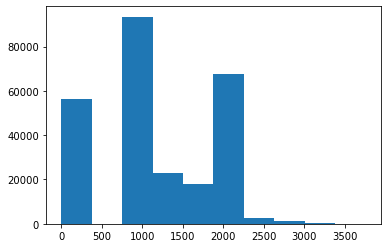

In [42]:
plt.hist(dcm.pixel_array.flatten());

1 frame per file
1 frame per file


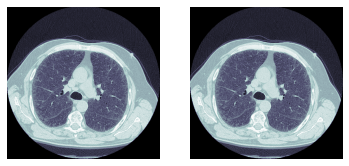

In [43]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.lungs, ax=axs[1])

In [44]:
scipy.stats.mode(d.flatten()).mode[0] #mode should be zero

0

In [45]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file
1 frame per file


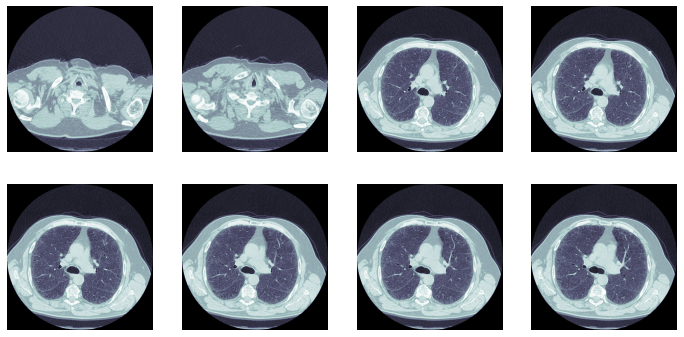

In [46]:
dcms = df2dcm(df_iffy)
dcms.map(fix_pxrepr)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

### Cropping to Lung Area Only

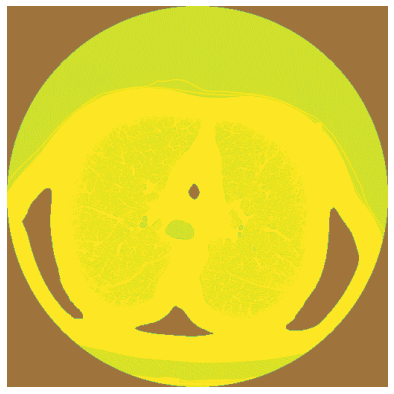

In [53]:
mask = dcm.mask_from_blur(dicom_windows.lungs)
wind = dcm.windowed(*dicom_windows.lungs)

_,ax = subplots(1,1, figsize=(7,7))
show_image(wind, ax=ax[0])
show_image(mask, alpha=0.5, ax=ax[0]);

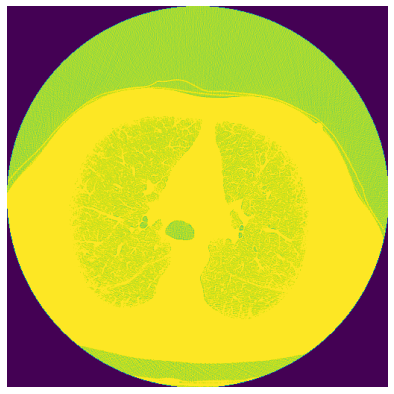

In [54]:
bbs = mask2bbox(mask)
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]], figsize = (7, 7));

In [55]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_square(cropped)

1 frame per file
1 frame per file
1 frame per file
1 frame per file


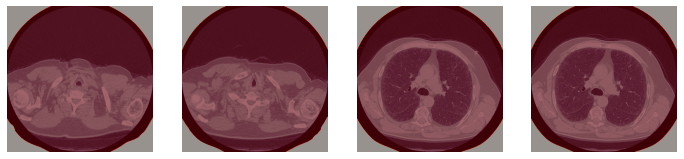

In [60]:
_,axs = subplots(1,4, imsize=3)
for i,ax in enumerate(axs.flat):
    dcms[i].show(dicom_windows.lungs, ax=ax)
    show_image(dcms[i].mask_from_blur(dicom_windows.lungs), cmap=plt.cm.Reds, alpha=0.6, ax=ax)

1 frame per file
1 frame per file
